In [21]:
import numpy as np
import pandas as pd

import pydot
import graphviz 
from ipywidgets import interactive
from IPython.display import SVG,display

from sklearn import tree

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
 


## Importando dados e pré-pré processando

In [2]:
df = pd.read_csv('../SVM/data.csv')
df


,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


In [3]:
features = df.drop(['target', 'song_title', 'id'], axis=1)
features.drop('artist', axis=1, inplace=True)
target = df['target']

In [5]:
target.head()
features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


## Treino e teste

In [6]:
Xtr, Xte, ytr, yte = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)


In [18]:
ytr.value_counts(normalize = True)
yte.value_counts(normalize = True)

target
1    0.50495
0    0.49505
Name: proportion, dtype: float64

## Modelos 

In [34]:
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True))
    ]),
    "Tree": tree.DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    )
}

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score
)

def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "train_acc": model.score(X_train, y_train),
        "test_acc": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics["roc_auc"] = roc_auc_score(y_test, y_proba)

    return metrics


In [36]:
results = {}

for name, model in models.items():
    results[name] = evaluate(
        model, Xtr, Xte, ytr, yte
    )




In [37]:
results


{'Dummy': {'train_acc': 0.5060240963855421,
  'test_acc': 0.504950495049505,
  'precision': 0.504950495049505,
  'recall': 1.0,
  'confusion_matrix': array([[  0, 300],
         [  0, 306]]),
  'roc_auc': 0.5},
 'Logistic': {'train_acc': 0.6697377746279235,
  'test_acc': 0.6716171617161716,
  'precision': 0.686411149825784,
  'recall': 0.6437908496732027,
  'confusion_matrix': array([[210,  90],
         [109, 197]]),
  'roc_auc': 0.7089596949891068},
 'SVM': {'train_acc': 0.8065201984408221,
  'test_acc': 0.7458745874587459,
  'precision': 0.7814814814814814,
  'recall': 0.6895424836601307,
  'confusion_matrix': array([[241,  59],
         [ 95, 211]]),
  'roc_auc': 0.8223366013071896},
 'Tree': {'train_acc': 0.8051027639971652,
  'test_acc': 0.6947194719471947,
  'precision': 0.7023411371237458,
  'recall': 0.6862745098039216,
  'confusion_matrix': array([[211,  89],
         [ 96, 210]]),
  'roc_auc': 0.7490141612200436}}

In [42]:
metricas = pd.DataFrame(results).T

In [43]:
metricas

,train_acc,test_acc,precision,recall,confusion_matrix,roc_auc
Dummy,0.506024,0.50495,0.50495,1.0,"[[0, 300], [0, 306]]",0.5
Logistic,0.669738,0.671617,0.686411,0.643791,"[[210, 90], [109, 197]]",0.70896
SVM,0.80652,0.745875,0.781481,0.689542,"[[241, 59], [95, 211]]",0.822337
Tree,0.805103,0.694719,0.702341,0.686275,"[[211, 89], [96, 210]]",0.749014


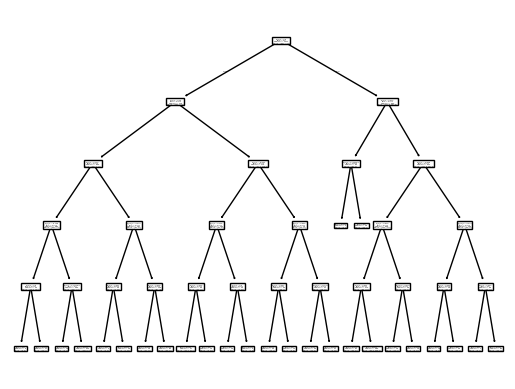

In [ ]:
#testando overfitting do decision trees
clf2 = tree.DecisionTreeClassifier(min_samples_leaf=3, max_depth=5, min_samples_split=10)
clf2.fit(Xtr, ytr)
from graphviz import Source    

In [67]:
Xtr.columns.tolist()

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

In [68]:
features_label = Xtr.columns
class_label = ['not_hit', 'hit']

In [ ]:
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = tree.DecisionTreeClassifier(
           random_state = 0 
          ,criterion = crit
          ,splitter = split
          ,max_depth = depth
          ,min_samples_split=min_split
          ,min_samples_leaf=min_leaf
    )

    estimator.fit(Xtr, ytr)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=features_label
      , class_names=class_label
      , filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=np.arange(1,100)
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [80]:
from IPython.display import display, Markdown

def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = tree.DecisionTreeClassifier(
        random_state=0,
        criterion=crit,
        splitter=split,
        max_depth=depth,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf
    )

    estimator.fit(Xtr, ytr)

    # === PREDIÇÕES ===
    ytr_pred = estimator.predict(Xtr)
    yte_pred = estimator.predict(Xte)

    # === MÉTRICAS ===
    train_acc = accuracy_score(ytr, ytr_pred)
    test_acc = accuracy_score(yte, yte_pred)

    # ROC AUC (se binário)
    if hasattr(estimator, "predict_proba"):
        yte_prob = estimator.predict_proba(Xte)[:, 1]
        roc = roc_auc_score(yte, yte_prob)
    else:
        roc = None

    # === EXIBIÇÃO DAS MÉTRICAS ===
    display(Markdown(f"""
### Métricas
- **Train accuracy:** {train_acc:.3f}
- **Test accuracy:** {test_acc:.3f}
- **ROC AUC:** {float(roc):.3f}
"""))

    # === ÁRVORE ===
    graph = Source(tree.export_graphviz(
        estimator,
        out_file=None,
        feature_names=features_label,
        class_names=class_label,
        filled=True
    ))
    display(SVG(graph.pipe(format='svg')))

    return estimator

inter = interactive(
    plot_tree,
    crit=["gini", "entropy"],
    split=["best", "random"],
    depth=np.arange(1, 30),
    min_split=(0.1, 1.0),
    min_leaf=(0.05, 0.5)
)

display(inter)


interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [81]:
cross_val_score(estimator, Xtr, ytr, cv=5)

NameError: name 'estimator' is not defined

In [82]:
clf = tree.DecisionTreeClassifier(
    random_state=0,
    criterion='gini',
    splitter='best',
    max_depth=10,
    min_samples_split=0.1,
    min_samples_leaf=0.01
)

In [83]:
clf.fit(Xtr, ytr)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",0.1
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",0.01
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [90]:
cross_val_score(clf, features, target, cv=5, scoring='roc_auc').mean()

np.float64(0.707902133215095)

In [88]:
print(classification_report(yte, clf.predict(Xte)))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       300
           1       0.69      0.63      0.66       306

    accuracy                           0.67       606
   macro avg       0.67      0.67      0.67       606
weighted avg       0.67      0.67      0.67       606



In [89]:
accuracy_score(yte, clf.predict(Xte))

0.66996699669967